# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

In [3]:
from models.load_models_1d import *
from dataloaders.load_1d_meteo_wtd import ContinuousDataset
from subprocess import Popen

# Load dictionary

In [4]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/continuous_1D_wtd/test_1D.json"
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'experiment_name': 'pizeo_head_1D', 'run_name': 'Random_fullDS_skip_softmax', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'gpu_idx': 0, 'test_split_p': '2018-01-01', 'all_dataset': True, 'max_ds_elems': 100000, 'normalization': True, 'date_max_norm': '2018-01-01', 'fill_value': 0, 'transf

# Dataset class

In [5]:
dict_files["piezo_head"] = True

In [6]:
ds = ContinuousDataset(dict_files)

Norm factors:
{'target_mean': np.float64(286.8112982044604), 'target_std': np.float64(84.84314496882753), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.81300000000007), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.37549999999999), 'lon_std': np.float64(0.43150656619183275), 'weather_mean': <xarray.Dataset> Size: 64B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.601
    tmax         float32 4B 12.35
    tmin         float32 4B 5.036
    tmean        float32 4B 8.692
    prain        float32 4B 2.052
    psnow        float32 4B 0.5488
    et_0         float64 8B 4.873
    r_a          float64 8B 26.37
    snowpack     float64 8B 16.33

In [7]:
ds[0][4].shape

torch.Size([31])

In [8]:
dict_files["gpu_idx"]

0

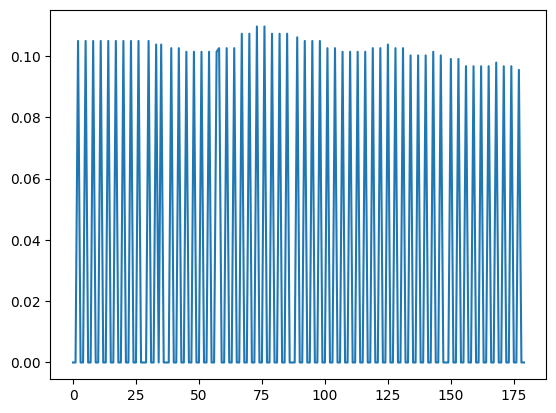

In [9]:
plt.plot(np.nan_to_num(ds[0][3].numpy()))

(290.0, 300.0)

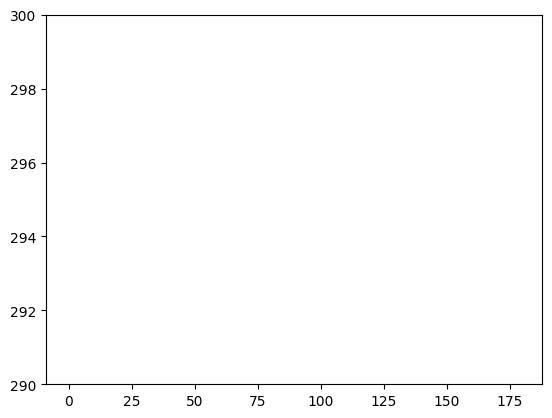

In [10]:
plt.plot(np.nan_to_num(ds[0][3].numpy()))
plt.ylim(290,300)

In [11]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 254820


# Model 

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [13]:
model = Continuous1DNN(timestep = dict_files["timesteps"],
                 cb_fc_layer = dict_files["cb_fc_layer"], #5,
                 cb_fc_neurons = dict_files["cb_fc_neurons"], # 32,
                 conv_filters = dict_files["conv_filters"], #32,
                 lstm_layer = dict_files["lstm_layer"], #5,
                 lstm_input_units = dict_files["lstm_input_units"], #16,
                 lstm_units = dict_files["lstm_units"] #32
                 ).to(device)

In [14]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  846721


In [16]:
ds[0][0][:,-1]

tensor([ 0.1049,  0.0828, -1.0698,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [17]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
weather_coords_batch = weather_coords
w = [ds[0][2].unsqueeze(0).expand(7, -1, -1, -1, -1),
     weather_coords_batch.unsqueeze(0).expand(7, -1, -1, -1)]

model(x = ds[0][0].unsqueeze(0).expand(7, -1, -1),
      z = ds[0][1].unsqueeze(0).expand(7, -1),
      w = w,
      x_mask = ds[0][4].unsqueeze(0).expand(7, -1))

tensor([[0.1284, 0.1284, 0.1283,  ..., 0.1281, 0.1282, 0.1283],
        [0.1284, 0.1284, 0.1283,  ..., 0.1281, 0.1282, 0.1283],
        [0.1284, 0.1284, 0.1283,  ..., 0.1281, 0.1282, 0.1283],
        ...,
        [0.1284, 0.1284, 0.1283,  ..., 0.1281, 0.1282, 0.1283],
        [0.1284, 0.1284, 0.1283,  ..., 0.1281, 0.1282, 0.1283],
        [0.1284, 0.1284, 0.1283,  ..., 0.1281, 0.1282, 0.1283]],
       grad_fn=<SqueezeBackward0>)

In [30]:
ds[0][4].unsqueeze(0).expand(7, -1).shape

torch.Size([7, 31])

In [34]:
multihead_attn = nn.MultiheadAttention(3, 1, batch_first=True, vdim=1)
attn_output, attn_output_weights = multihead_attn(query = ds[0][1][None, None, :].expand(7, -1, -1), #(N,L,E)
                                                  key = ds[0][0].unsqueeze(0).expand(7, -1, -1)[:,:,:3],
                                                  value = ds[0][0].unsqueeze(0).expand(7, -1, -1)[:,:,-1].unsqueeze(-1),
                                                  key_padding_mask = ~ds[0][4].unsqueeze(0).expand(7, -1), #(N,S)
                                                   ) 

In [35]:
attn_output

tensor([[[-0.0292,  0.0296, -0.0064]],

        [[-0.0292,  0.0296, -0.0064]],

        [[-0.0292,  0.0296, -0.0064]],

        [[-0.0292,  0.0296, -0.0064]],

        [[-0.0292,  0.0296, -0.0064]],

        [[-0.0292,  0.0296, -0.0064]],

        [[-0.0292,  0.0296, -0.0064]]], grad_fn=<TransposeBackward0>)

In [38]:
ds[0][0].unsqueeze(0).expand(7, -1, -1)[:,:,-1]

tensor([[ 0.1049,  0.0828, -1.0698,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1049,  0.0828, -1.0698,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1049,  0.0828, -1.0698,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1049,  0.0828, -1.0698,  0.0000,  0.0000

In [37]:
nn.functional.scaled_dot_product_attention(query = ds[0][1][None, None, :].expand(7, -1, -1), #(N,L,E)
                                            key = ds[0][0].unsqueeze(0).expand(7, -1, -1)[:,:,:3],
                                            value = ds[0][0].unsqueeze(0).expand(7, -1, -1)[:,:,-1].unsqueeze(-1))

tensor([[[-0.0339]],

        [[-0.0339]],

        [[-0.0339]],

        [[-0.0339]],

        [[-0.0339]],

        [[-0.0339]],

        [[-0.0339]]])

# PDE loss sketch

In [ ]:
# define the lower and upper limits for x and y
minX, maxX, minY, maxY = 0., 20000., 10000., 50000.
# create one-dimensional arrays for x and y
x = np.linspace(minX, maxX, (maxX-minX)/2000.+1)
y = np.linspace(minY, maxY, (maxY-minY)/2000.+1)
# create the mesh based on these arrays
X, Y = np.meshgrid(x, y)

In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def physics_loss(model: torch.nn.Module):
    control_points_x_ode = torch.linspace(-100, 100, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    control_points_y_ode = model(control_points_x_ode)
    ode_est = grad(control_points_y_ode, control_points_x_ode)[0]
    pde = 2*control_points_x_ode - ode_est
    
    return torch.mean(pde**2)

# Training

In [8]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 203856, Test size: 50964


In [9]:
def plot_predictions(x, y, y_hat, save_dir = None, title = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(x, y_hat, label = "predicted")
    ax.plot(x, y, label = "true")
    ax.legend()
    
    if title is not None:
        ax.set_title(title)
        
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    return fig

In [10]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
wandb.init(
    entity="gsartor-unito",
    project=dict_files["experiment_name"],
    dir =dict_files["wandb_dir"],
    config=dict_files,
    mode="offline",
)

# Magic
wandb.watch(model, log_freq=100)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


mem allocated in MB:  0.0
############### Training epoch 0 ###############


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 0:   0%|          | 0/250 [00:02<?, ?batch/s]

Train loss: 425.80499267578125


Epoch 0:   0%|          | 1/250 [00:11<35:03,  8.45s/batch]

Train loss: 480.5107116699219


Epoch 0:   0%|          | 1/250 [00:16<1:09:58, 16.86s/batch]


############### Test epoch 0 ###############


Epoch 0:   2%|▏         | 1/63 [00:04<04:44,  4.59s/batch]

Test loss: 425.613525390625


Epoch 0:   2%|▏         | 1/63 [00:09<09:36,  9.29s/batch]


Test loss: 480.4068298339844
############### Training epoch 1 ###############


  0%|          | 0/250 [00:01<?, ?batch/s]


KeyboardInterrupt: 

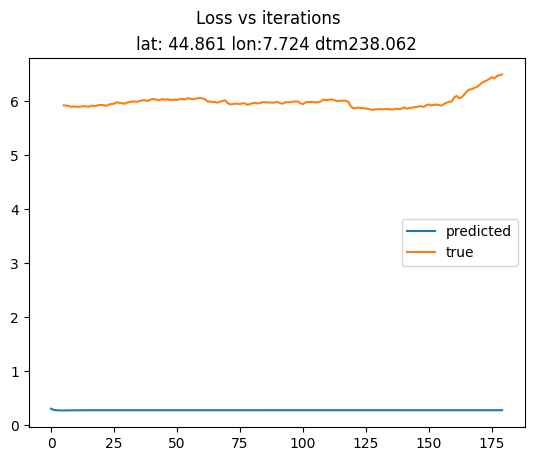

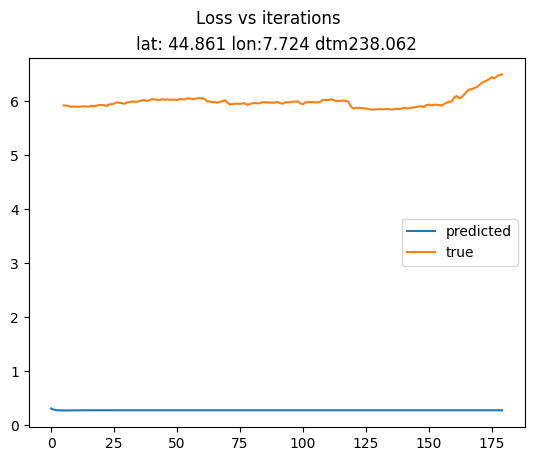

In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

print('mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

for i in range(max_epochs):
    
    model.train(True)
    start_time = time.time()
    print(f"############### Training epoch {i} ###############")
    
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                
                x = x.to(device)
                x_mask = x_mask.to(device)
                z = z.to(device)
                weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                w = [w_values.to(device), weather_coords_batch.to(device)]
                y = y.to(device)
                y_mask = y_mask.to(device)
                #print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
                
                optimizer.zero_grad()
                
                y_hat = model(x, z, w, x_mask)
                #print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
                loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                
                print(f"Train loss: {loss}")
                
                loss.backward()
                optimizer.step()
                
                metrics = {
                    "train_loss" : loss
                }
                wandb.log(metrics) 
                
                if batch_idx == 1:
                    break             
                
    end_time = time.time()
    exec_time = end_time-start_time

    wandb.log({"tr_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"training_pred":wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]),
                                                 y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })

    model_name = 'model_{}_{}.pt'.format(timestamp, i)    
    model_dir = dict_files["save_model_dir"]
    torch.save(model.state_dict(), f"{model_dir}/{model_name}") 

    print(f"############### Test epoch {i} ###############")
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    start_time = time.time()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    # print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    y_hat = model(x, z, w, x_mask)
                    # print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    print(f"Test loss: {loss}")

                    metrics = {
                        "test_loss" : loss
                    }

                    wandb.log(metrics)
                    
                    if batch_idx == 1:
                        break  
        
    end_time = time.time()
    exec_time = end_time-start_time
    wandb.log({"test_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"test_pred": wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]), y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })


wandb.finish()

print(f"Execution time: {end_time-start_time}s")

# Physics loss

In [ ]:
# grad function

In [ ]:
def physics_loss(model: torch.nn.Module):
    control_points_x_ode = torch.linspace(-100, 100, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    control_points_y_ode = model(control_points_x_ode)
    ode_est = grad(control_points_y_ode, control_points_x_ode)[0]
    pde = 2*control_points_x_ode - ode_est
    
    # Metti temporal encoding in input? 
    pde = 
    pde_res = 
    
    return torch.mean(pde**2)

# Test plots

In [13]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)
#offset_idx = 100000

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx,
                                                        train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=31,
                                            sampler=test_sampler)

Traing size: 203856, Test size: 50964


In [17]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models/model_20241231_124957.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

Continuous1DNN(
  (wgamma): Sigmoid()
  (cb_fc): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=256, bias=True)
  )
  (weather_wgamma): Sigmoid()
  (conv3d_stack): Sequential(
    (0): Conv3d(10, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (10): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1

In [14]:
def masked_mse(y_hat, y, mask):
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

def masked_mae(y_hat, y, mask):
    return torch.sum(torch.abs((y_hat[mask]-y[mask])))  / torch.sum(mask)

In [16]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

y_list = []
y_hat_list = []
mse_list = []
mae_list = []

with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    #tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    
                    y_hat = model(x, z, w, x_mask)
                    # denormalize 
                    y_hat = (y_hat * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
                    y = (y * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
                    
                    y_list.append(y)
                    y_hat_list.append(y_hat)

                    mse = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    mse_list.append(mse)
                    
                    mae = masked_mae(y_hat,
                                  y,
                                  y_mask)
                    mae_list.append(mae)
                    
                    if batch_idx == 5:
                        break

  0%|          | 0/1644 [00:00<?, ?batch/s]/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([31, 31])
torch.Size([31, 14, 180, 9, 12])


  0%|          | 1/1644 [00:02<1:13:13,  2.67s/batch]/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([31, 31])
torch.Size([31, 14, 180, 9, 12])


  0%|          | 2/1644 [00:05<1:11:31,  2.61s/batch]/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([31, 31])
torch.Size([31, 14, 180, 9, 12])


  0%|          | 3/1644 [00:07<1:12:22,  2.65s/batch]/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([31, 31])
torch.Size([31, 14, 180, 9, 12])


  0%|          | 4/1644 [00:10<1:15:08,  2.75s/batch]/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([31, 31])
torch.Size([31, 14, 180, 9, 12])


  0%|          | 5/1644 [00:13<1:13:34,  2.69s/batch]/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([31, 31])
torch.Size([31, 14, 180, 9, 12])


  0%|          | 5/1644 [00:15<1:27:02,  3.19s/batch]


In [19]:
sample_day = 0

In [35]:
#ds.wtd_names["munic"].loc[ds.wtd_names["sensor_id"] == ds.wtd_df["sensor_id"].loc[:, ds[0][1][0], ds[0][1][1]]]

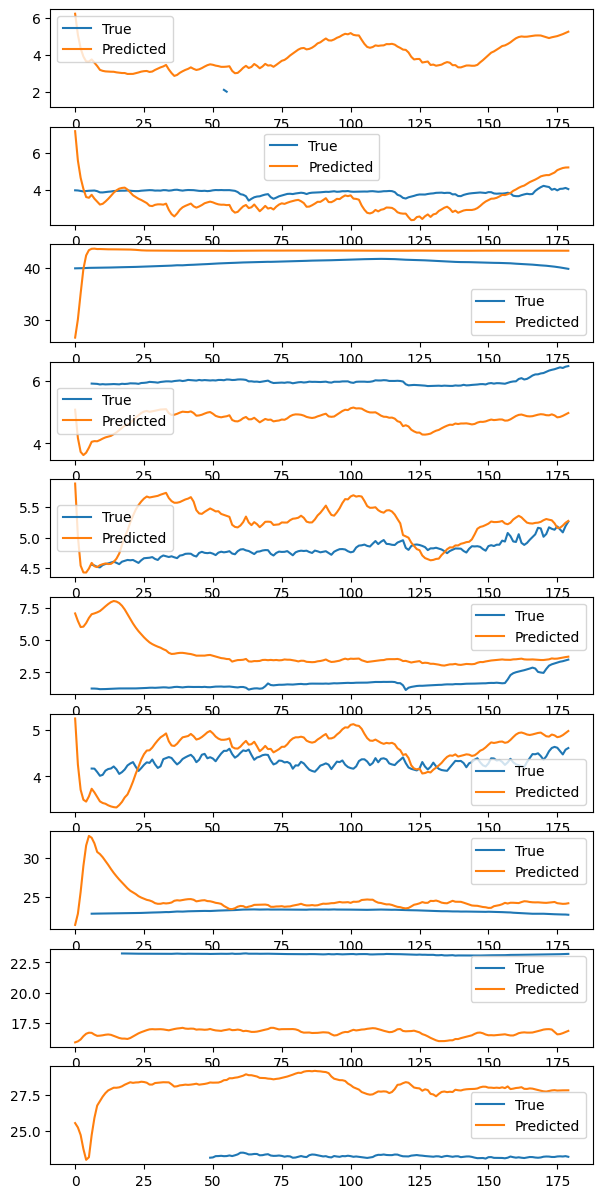

In [20]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10):
        ax[i].plot(np.arange(180), y_list[3][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i].plot(np.arange(180), y_hat_list[3][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i].legend()

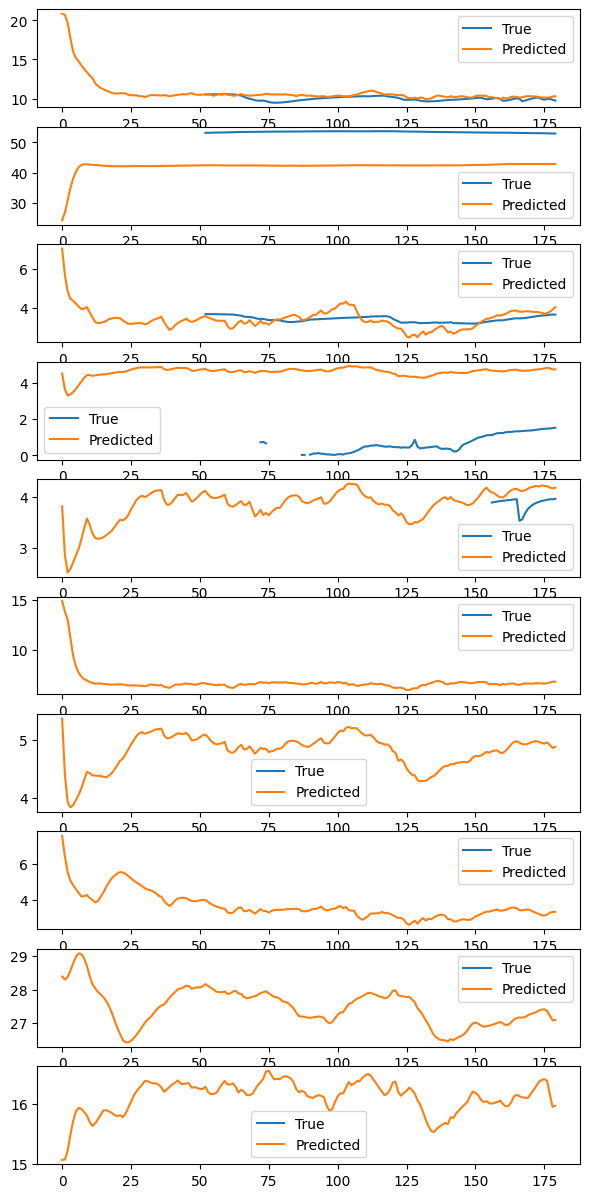

In [21]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10,20):
        ax[i-10].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-10].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-10].legend()

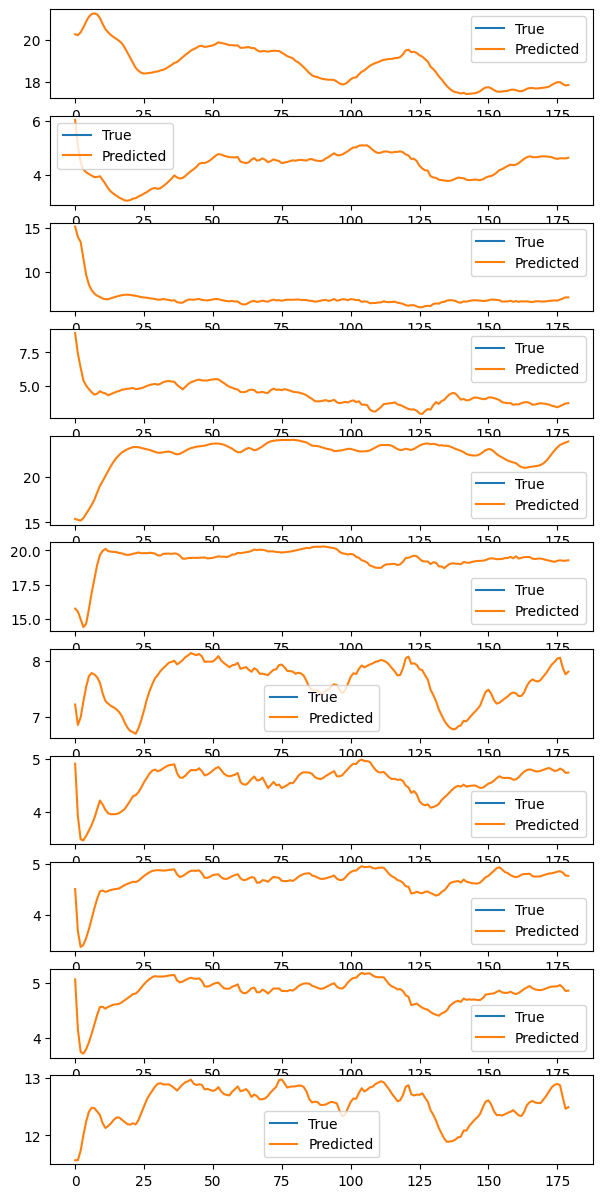

In [22]:
fig, ax = plt.subplots(11, figsize = (7,15))
for i in range(20,31):
        ax[i-20].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-20].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-20].legend()

In [ ]:
MAE = nn.L1Loss()
MSE = nn.MSELoss()

# Compute MAE
output_tensor = MAE(test_prediction, test_target)

# Compute RMSE
RMSE = MSE(test_prediction, test_target)
RMSE = torch.sqrt(RMSE)

print("MAE: ", MAE)
print("RSME: ", RMSE)